In [42]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import pyiqa

# 路径：注意 notebook 在 ./notebooks/ 下
OHAZE_HAZY_DIR = "../data/OHAZE/hazy"
OHAZE_DCP_DIR  = "../results/dcp/o-haze"
METRICS_DIR    = "../metrics"

os.makedirs(OHAZE_DCP_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

hazy_files = sorted(
    f for f in os.listdir(OHAZE_HAZY_DIR)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
)

len(hazy_files), hazy_files[:5]


(3, ['myhaze1.jpg', 'myhaze2.jpg', 'myhaze3.jpg'])

In [43]:
def dark_channel(im, size=15):
    """
    im: float32, [0,1], shape (H,W,3)
    """
    b, g, r = cv2.split(im)
    min_img = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark = cv2.erode(min_img, kernel)
    return dark

def estimate_atmospheric_light(im, dark, top_percent=0.001):
    h, w = dark.shape
    num_pixels = max(int(h * w * top_percent), 1)
    dark_vec = dark.reshape(-1)
    im_vec   = im.reshape(-1, 3)
    indices = np.argsort(dark_vec)[-num_pixels:]
    A = im_vec[indices].mean(axis=0)
    return A

def estimate_transmission(im, A, omega=0.95, size=15):
    norm_im = im / A
    t = 1 - omega * dark_channel(norm_im, size)
    return t

def recover_image(im, t, A, t0=0.1):
    t = np.clip(t, t0, 1)
    J = (im - A) / t[:, :, None] + A
    J = np.clip(J, 0, 1)
    return J

def dehaze_dcp(image_path, size=31, omega=0.88, t0=0.15, smooth=True):
    """
    使用你调好的最优参数：size=31, omega=0.88, t0=0.15
    """
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    dark = dark_channel(im, size=size)
    A    = estimate_atmospheric_light(im, dark)
    t    = estimate_transmission(im, A, omega=omega, size=size)

    if smooth:
        t = cv2.blur(t, (15, 15))

    J    = recover_image(im, t, A, t0=t0)
    J8   = (J * 255).astype(np.uint8)
    return J8


Dehazing O-HAZE with DCP:   0%|          | 0/3 [00:00<?, ?it/s]

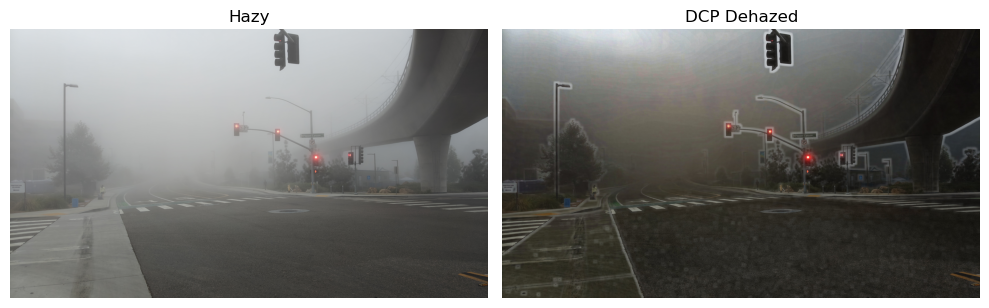

In [44]:
for fname in tqdm(hazy_files, desc="Dehazing O-HAZE with DCP"):
    hazy_path = os.path.join(OHAZE_HAZY_DIR, fname)
    out_path  = os.path.join(OHAZE_DCP_DIR,  fname)

    J = dehaze_dcp(hazy_path, size=31, omega=0.88, t0=0.15)

    cv2.imwrite(out_path, cv2.cvtColor(J, cv2.COLOR_RGB2BGR))


test_name = hazy_files[0]

hazy = cv2.cvtColor(cv2.imread(os.path.join(OHAZE_HAZY_DIR, test_name)), cv2.COLOR_BGR2RGB)
dcp  = cv2.cvtColor(cv2.imread(os.path.join(OHAZE_DCP_DIR,  test_name)), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(hazy); plt.title("Hazy"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(dcp);  plt.title("DCP Dehazed"); plt.axis("off")
plt.tight_layout()
plt.show()


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

niqe_metric     = pyiqa.create_metric('niqe', device=device)
brisque_metric  = pyiqa.create_metric('brisque', device=device)


Using device: cuda


In [46]:
def img_to_tensor_for_pyiqa(img_bgr, device):
    """
    img_bgr: OpenCV 读出来的 BGR uint8 图 (H,W,3)
    返回: (1,3,H,W) 的 float32 tensor, RGB, [0,1]
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img_t   = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).to(device)
    return img_t


In [47]:
niqe_rows = []

for fname in tqdm(hazy_files, desc="Computing NIQE (hazy vs DCP)"):
    hazy_path = os.path.join(OHAZE_HAZY_DIR, fname)
    dcp_path  = os.path.join(OHAZE_DCP_DIR,  fname)

    hazy_bgr = cv2.imread(hazy_path)
    dcp_bgr  = cv2.imread(dcp_path)

    if hazy_bgr is None or dcp_bgr is None:
        print("Skip (cannot read):", fname)
        continue

    hazy_t = img_to_tensor_for_pyiqa(hazy_bgr, device)
    dcp_t  = img_to_tensor_for_pyiqa(dcp_bgr,  device)

    score_hazy = float(niqe_metric(hazy_t))
    score_dcp  = float(niqe_metric(dcp_t))

    niqe_rows.append((fname, score_hazy, score_dcp))

df_niqe = pd.DataFrame(niqe_rows, columns=["file", "niqe_hazy", "niqe_dcp"])
df_niqe["delta"] = df_niqe["niqe_hazy"] - df_niqe["niqe_dcp"]   # 正值说明去雾后更自然（分数更低）

df_niqe.to_csv(os.path.join(METRICS_DIR, "dcp_ohaze_niqe_pyiqa.csv"), index=False)

df_niqe.head(), df_niqe[["niqe_hazy","niqe_dcp","delta"]].describe()


Computing NIQE (hazy vs DCP):   0%|          | 0/3 [00:00<?, ?it/s]

(          file  niqe_hazy  niqe_dcp     delta
 0  myhaze1.jpg   4.391515  3.746015  0.645501
 1  myhaze2.jpg   3.461010  3.234410  0.226600
 2  myhaze3.jpg   3.302803  3.049149  0.253654,
        niqe_hazy  niqe_dcp     delta
 count   3.000000  3.000000  3.000000
 mean    3.718443  3.343191  0.375252
 std     0.588241  0.360944  0.234433
 min     3.302803  3.049149  0.226600
 25%     3.381907  3.141780  0.240127
 50%     3.461010  3.234410  0.253654
 75%     3.926263  3.490212  0.449577
 max     4.391515  3.746015  0.645501)

In [41]:
brisque_rows = []

for fname in tqdm(hazy_files, desc="Computing BRISQUE (hazy vs DCP)"):
    hazy_path = os.path.join(OHAZE_HAZY_DIR, fname)
    dcp_path  = os.path.join(OHAZE_DCP_DIR,  fname)

    hazy_bgr = cv2.imread(hazy_path)
    dcp_bgr  = cv2.imread(dcp_path)

    if hazy_bgr is None or dcp_bgr is None:
        print("Skip (cannot read):", fname)
        continue

    hazy_t = img_to_tensor_for_pyiqa(hazy_bgr, device)
    dcp_t  = img_to_tensor_for_pyiqa(dcp_bgr,  device)

    score_hazy = float(brisque_metric(hazy_t))
    score_dcp  = float(brisque_metric(dcp_t))

    brisque_rows.append((fname, score_hazy, score_dcp))

df_brisque = pd.DataFrame(brisque_rows, columns=["file", "brisque_hazy", "brisque_dcp"])
df_brisque["delta"] = df_brisque["brisque_hazy"] - df_brisque["brisque_dcp"]  # 正值说明去雾后更好（分数更低）

df_brisque.to_csv(os.path.join(METRICS_DIR, "dcp_ohaze_brisque_pyiqa.csv"), index=False)

df_brisque.head(), df_brisque[["brisque_hazy","brisque_dcp","delta"]].describe()


Computing BRISQUE (hazy vs DCP):   0%|          | 0/45 [00:00<?, ?it/s]

(                  file  brisque_hazy  brisque_dcp      delta
 0  01_outdoor_hazy.jpg     28.077820    21.315613   6.762207
 1  02_outdoor_hazy.jpg     22.404480    17.522644   4.881836
 2  03_outdoor_hazy.JPG     17.158386    11.738953   5.419434
 3  04_outdoor_hazy.jpg     22.458191    13.925476   8.532715
 4  05_outdoor_hazy.jpg     20.292175    10.237000  10.055176,
        brisque_hazy  brisque_dcp      delta
 count     45.000000    45.000000  45.000000
 mean      22.971179    16.208918   6.762261
 std        3.481481     3.697642   4.699651
 min       15.812195     9.188171  -5.307129
 25%       21.047546    14.133972   3.396484
 50%       22.404480    16.203308   6.289551
 75%       24.778015    18.349304   8.841309
 max       33.506531    24.378601  18.783203)